In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import pickle as pkl
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,make_scorer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
from math import log
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.patches as mpatches
# %pylab inline

def plot_prob_timeline(data,label):
    xtick = range(0, 91, 10)
    fig = plt.figure()
    a = plt.plot(data[:,0])
    d = plt.plot(data[:,1])
    h = plt.plot(data[:,2])
    fig.suptitle(label, fontsize=20)
    dim = 300
    plt.ylim([0,1])

    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Probability', fontsize=16)
    blue_patch = mpatches.Patch(color='blue', label='Away')
    orange_patch = mpatches.Patch(color='orange', label='Draw')
    green_patch = mpatches.Patch(color='green', label='Home')

    plt.legend(handles=[blue_patch,orange_patch,green_patch])
    plt.xticks(xtick)
    plt.show()
    return fig
def round_nearest(x, a):
    return round(x/a) *a;
def eval_probs(y_prob,y_test, labels=[-1,0,1],show_plot=False):
    """
    y_prob : predict_proba output of a model
    labels : all unique labels in the classification
    """
    vals = []
    titles = {}
    titles[-1] = "Away Win"
    titles[0] = "Draw"
    titles[1] = "Home Win"

    y_prob = pd.DataFrame(y_prob, columns=[-1, 0, 1])
#     y_prob = y_prob.round(2)
    for key in y_prob:
        y_prob[key] = [round_nearest(i,0.05) for i in y_prob[key]]
    
    y_prob['label'] = y_test.reset_index(drop=True)
    slopes= []
    total_error = 0
    for ind, label in enumerate(labels):
        vals = sorted(y_prob[label].unique())
        
        y_col = []
        
        
        for i in vals:
            tot_len = y_prob[(y_prob[label] == i)].shape[0]
            matching_len = y_prob[(y_prob[label] == i) & (y_prob['label'] == label)].shape[0]
            y_col.append(matching_len*1.0/tot_len)
        
        index = 0
        y_true = 0
        for i in range(21):
            if index == len(y_col):
                y = 0
            else:
                y = y_col[index]
                index+=1
            total_error+= (y_true - y)**2
            y_true+=0.05
#         perfect_values = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        perfect_values = [0.05*i for i in range(21)]
        if show_plot:
            plt.figure(figsize=(7,21))
            plt.subplot(311+ind)
            plt.scatter(vals, y_col,label="Model Performance")
            plt.title(titles[label], fontsize=16)
            plt.xticks([0.1*i for i in range(11)], fontsize=12)
            plt.yticks([0.1*i for i in range(11)],fontsize=12)
            plt.plot(perfect_values,perfect_values,'r--',label="Ideal Values")
            plt.legend(loc=0)
            plt.show()
    return total_error ** 0.5
        
    
def save_model(model, model_name):
    saved_models_root = "./saved_models/" 
    filename = saved_models_root + model_name + datetime.now().strftime('%m%d_%H%M%S') + ".pkl"
                                                 
    with open(filename, 'wb') as outfile:
        pkl.dump(model, outfile)

In [2]:
with open("./data/train/train_data.pkl") as infile:
    train_data = pkl.load(infile)
train_data = train_data.loc[train_data['match_id'] != 1510605206930]
train_data.shape

(152073, 106)

In [3]:
temp_data = train_data.copy(deep = True)


In [4]:
columns = ['date', 'B365H', 'B365D', 'B365A', 'home_team', 'away_team', 
           'winner', 'minute', 'H_Goal', 'A_Goal','goal_diff','home_avg_player_rating',
       'home_avg_player_potential', 'away_avg_player_rating',
       'away_avg_player_potential','H_Y_Card', 'A_Y_Card', 'H_R_Card', 'A_R_Card']
def preprocessData(train_data):
    train_data['goal_diff'] = train_data['H_Goal'] - train_data['A_Goal']
    train_data = train_data[columns]
    train_data.drop_duplicates(inplace=True, keep='first')
    X = train_data.drop(['winner', 'date', 'home_team', 'away_team'], axis=1)
    Y = train_data['winner']
    return (X,Y)

In [5]:
(X,Y) = preprocessData(train_data)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)


## Support Vector Classifier

In [ ]:
svc = svm.SVC(probability=True,cache_size=99999)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = svc.predict_proba(X_test)

## Logistic Regression

In [8]:
temp_cols = ['B365H', 'B365D', 'B365A','minute', 'H_Goal', 'A_Goal']
lr = LogisticRegression(n_jobs=-1,solver='saga',class_weight='balanced')
X_train = X_train[temp_cols]
X_test = X_test[temp_cols]
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

0.632993944234


In [9]:
y_prob = lr.predict_proba(X_test)

# eval_probs(y_prob, y_test, [-1,0,1])

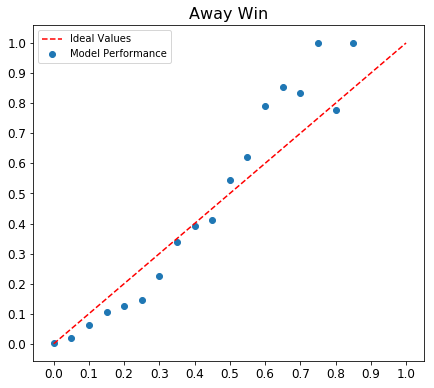

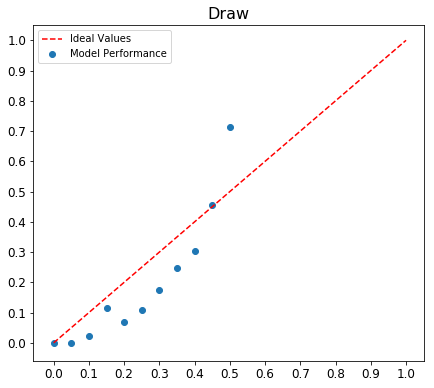

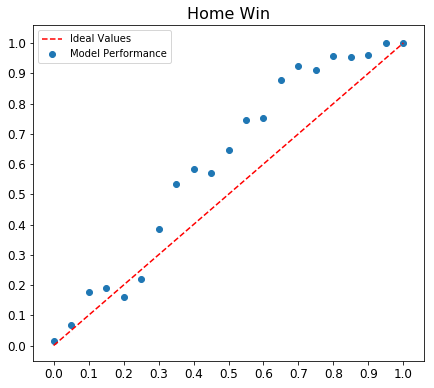

3.101633966714116

In [10]:
eval_probs(y_prob, y_test, [-1,0,1], True)

## K nearest neighbours

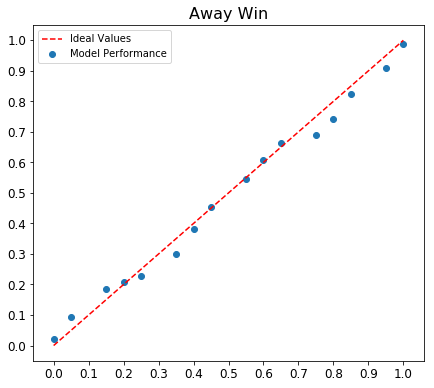

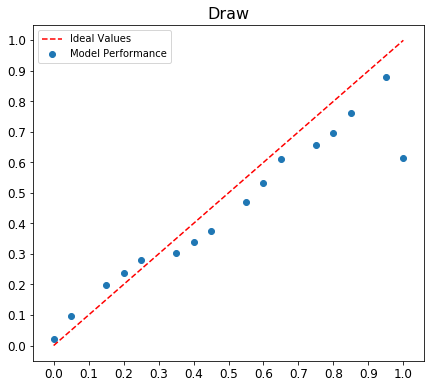

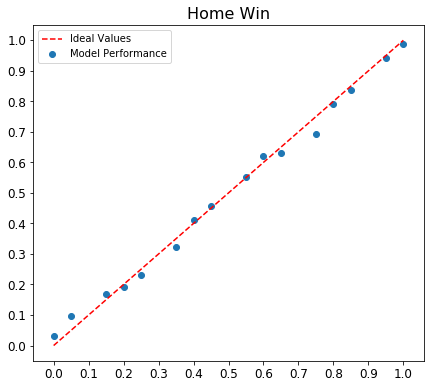

3.59982263767


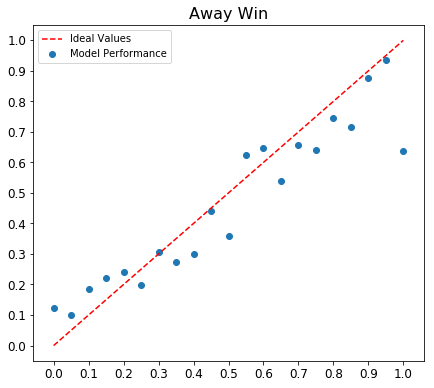

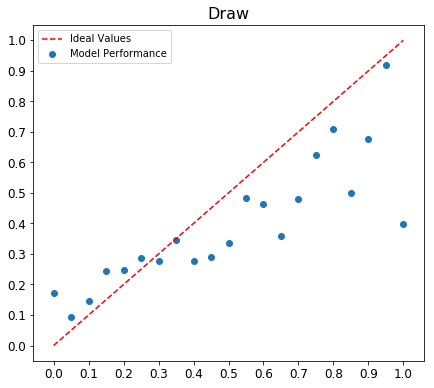

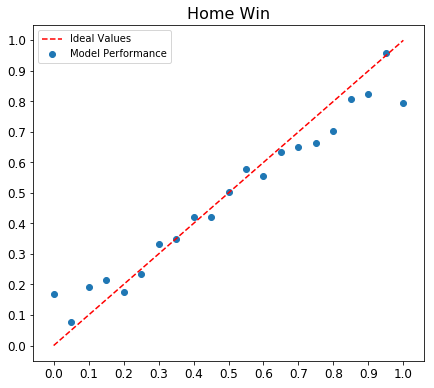

1.09657029801


In [12]:
for weight in ['uniform' , 'distance']:

    neigh = KNN(n_neighbors=15, algorithm='auto', weights=weight, n_jobs=-1)
    neigh.fit(X_train, y_train) 
    
    y_pred = neigh.predict(X_test)

    y_prob = neigh.predict_proba(X_test)
    print eval_probs(y_prob, y_test, [-1,0,1],show_plot=True)    
    
    


## Random Forest Classifier

0.702934717508


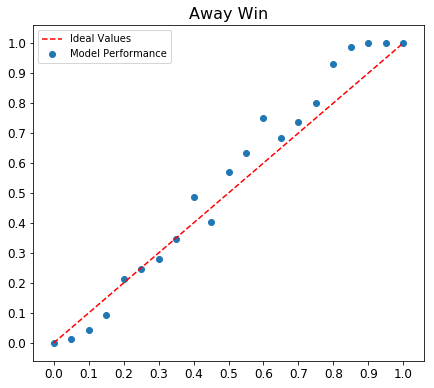

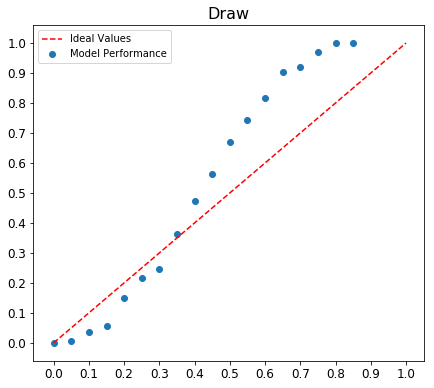

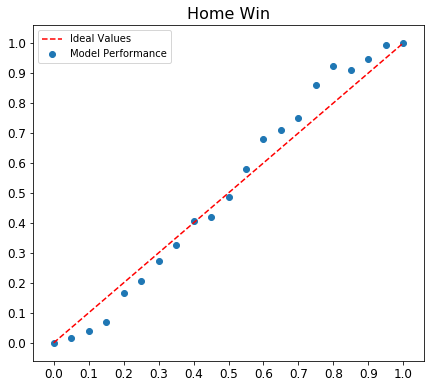

1.8052021412341364

In [13]:
rf = RandomForestClassifier(n_estimators=15,max_depth=8,n_jobs=-1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = rf.predict_proba(X_test)

eval_probs(y_prob, y_test, [-1,0,1],show_plot=True)

0


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


1


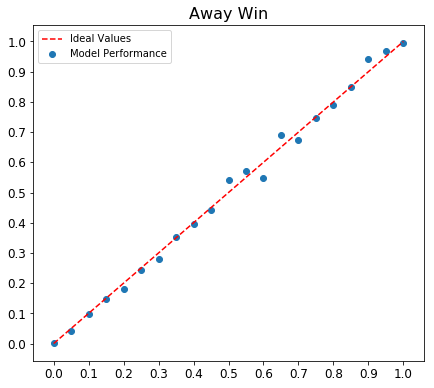

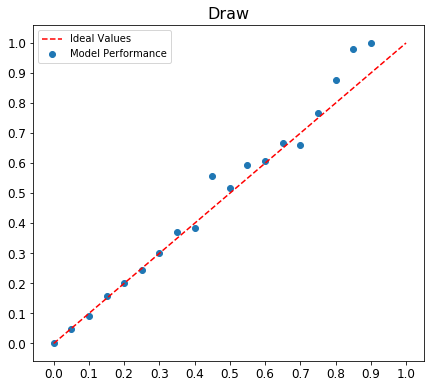

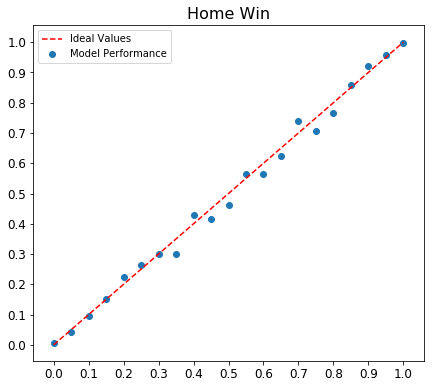

1.4060098853903085

In [7]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='tanh', solver='adam', learning_rate='constant',
                   learning_rate_init=0.0001, max_iter=100, early_stopping=False, tol=0.00001, verbose=False,
                   warm_start=True)

for i in range(2):
    print i
    mlp.fit(X_train,y_train)
    if i>300 and i%10 == 0:
        y_pred = mlp.predict(X_test)
        y_prob = mlp.predict_proba(X_test)
        error =  eval_probs(y_prob, y_test, [-1,0,1],show_plot=False)
        print error
        if error <=1.08:
            eval_probs(y_prob, y_test, [-1,0,1],show_plot=True)

y_pred = mlp.predict(X_test)

# print metrics.accuracy_score(y_test, y_pred)

y_prob = mlp.predict_proba(X_test)

eval_probs(y_prob, y_test, [-1,0,1],show_plot=True)

In [8]:
with open("./data/train/train_data.pkl") as infile:
    temp_data = pkl.load(infile)


In [9]:
match_ids = temp_data['match_id']

In [10]:
plot_data = temp_data.loc[temp_data['match_id'] == 1510573681650]
X,Y= preprocessData(plot_data)
y_prob = mlp.predict_proba(X)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(91L, 3L)


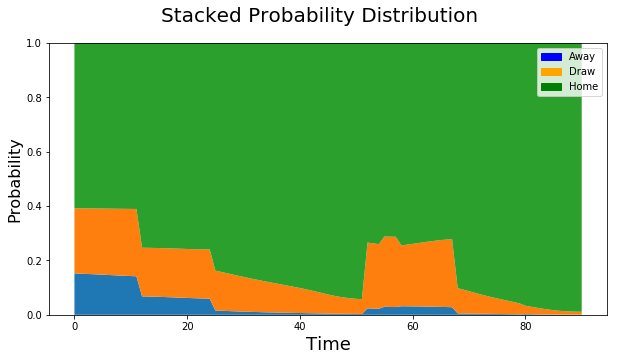

In [11]:
data = y_prob
label = "Stacked Probability Distribution"
# x = range(0, 91, 10)
# fig = plt.figure()
x = np.arange(data.shape[0])
fig, ax = plt.subplots()
print y_prob.shape
fig.suptitle(label, fontsize=20)
plt.ylim([0,1])
fig.set_figheight(5)
fig.set_figwidth(10)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Probability', fontsize=16)
blue_patch = mpatches.Patch(color='blue', label='Away')
orange_patch = mpatches.Patch(color='orange', label='Draw')
green_patch = mpatches.Patch(color='green', label='Home')

plt.legend(handles=[blue_patch,orange_patch,green_patch])
y_prob.reshape(3,-1)
temp =y_prob.T
ax.stackplot(x, temp)
plt.show()


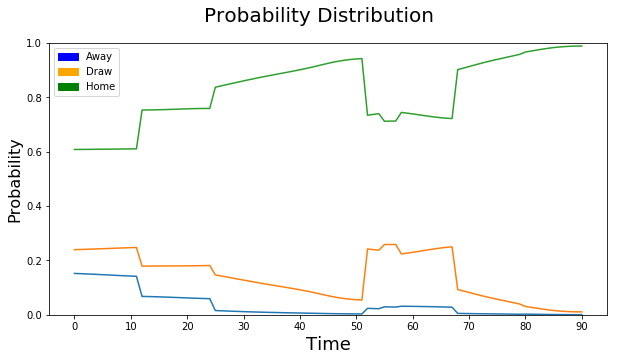

In [12]:
label = "Probability Distribution"
xtick = range(0, 91, 10)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)
a = plt.plot(data[:,0])
d = plt.plot(data[:,1])
h = plt.plot(data[:,2])
fig.suptitle(label, fontsize=20)
dim = 300
plt.ylim([0,1])

plt.xlabel('Time', fontsize=18)
plt.ylabel('Probability', fontsize=16)
blue_patch = mpatches.Patch(color='blue', label='Away')
orange_patch = mpatches.Patch(color='orange', label='Draw')
green_patch = mpatches.Patch(color='green', label='Home')

plt.legend(handles=[blue_patch,orange_patch,green_patch])
plt.xticks(xtick)
plt.show()